# Problem Statement

Consider a single measurement vector (SMV) linear regression model $${\bf y}={\bf X}\boldsymbol{\beta}+{\bf w}$$ where ${\bf X} \in \mathbb{R}^{n\times p} $ is a known design matrix and $\boldsymbol{\beta} \in \mathbb{R}^{p\times 1}$ is an unknown sparse vector.  ${\bf w} \in \mathbb{R}^{n\times 1}$ is a noise vector (for theoretical purposes only)  with each entries $\mathcal{N}(0,\sigma^2)$ distributed.  In model order selection problem, the actual support of $\boldsymbol{\beta}$ is known a priori to be of the form $\mathcal{S}=\{1,2,..k_0\}$. Here $k_0$ is called the model order. Since this prior information regarding the support of $\boldsymbol{\beta}$ is known, we consider a set of candidate support estimates $\mathcal{S}_1=\{1\},\mathcal{S}_2=\{1,2\},\dotsc,...\mathcal{S}_p=\{1,2,..p\}$ and we have to select the correct support from this candidate sequence.  Unlike unstructured support estimation problems where the optimal estimate involves a  search over $2^p$ candidates when $k_0$ is unknown or $O(p^{k_0})$ candidates when $k_0$ is known, estimating support in model order selection problems involves a search over just $p$ candidates. In these problems, $k_0$ fully encodes $\mathcal{S}$.      


In our 2018 ICML paper http://proceedings.mlr.press/v80/kallummil18a.html we proposed residual ratio thresholding (RRT) as a tool to estimate $\boldsymbol{\beta}$ using OMP in a single measurement vector scenario without requiring $\textit{a priori}$ knowledge of sparsity and/or $\sigma^2$. In another article (https://ieeexplore.ieee.org/document/8573899), we proposed this concept to model order selection problem. This notebook implements the ideas in this paper.   

# Concept  of RRT

In MOS we are  given an ordered sequence of support estimates $\mathcal{S}_1=\{1\},\mathcal{S}_2=\{1,2\}...\mathcal{S}_{p}=\{1,2,..,p\}$.  Corresponding to each support $\mathcal{S}_k$, one can compute the corresponding least squares residuals as ${\bf R}^k=({\bf I}_{n}-{\bf P}(\mathcal{S}_k)){\bf Y}$, where ${\bf P}(\mathcal{S}_k)$ is the projection onto the subspace spanned by the columns in ${\bf X}[:,\mathcal{S}_k]$.  The corresponding residual ratios are defined as $$RR(k)=\dfrac{\|{\bf R}^k\|_2}{\|{\bf R}^{k-1}\|_2}$$. 

This statistic satisfies some interesting properties. For starters, $$0\leq RR(k)\leq 1$$

$$1). \ \ RR(k_0)\rightarrow 0  \ \text{as} \ \sigma^2\rightarrow 0$$.  

$$2). \ \ \mathbb{P}(RR(k)>\Gamma_{RRT}^{\alpha}(k),\ \text{for all} \ k=k_0+1,\dotsc,p)>1-\alpha$$

where $$\Gamma_{RRT}^{\alpha}(k)=\sqrt{F_{\dfrac{n-k}{2},\dfrac{1}{2}}^{-1}\left(\dfrac{\alpha}{p}\right)}$$
is a sequence of RRT thresholds. $F_{a,b}(x)$ is the CDF of a Beta random variable with parameters $a$ and $b$ and $F^{-1}$ is the inverse function of $F$.  

Properties 1 and 2 of $RR(k)$ means that the RRT estimate of sparsity given by $$k_{RRT}=\max\{k:RR(k)\leq \Gamma_{RRT}^{\alpha}(k)\}$$ will be equal to true unknown  sparsity $k_0$ and $\mathcal{S}_{k_{RRT}}$ will be equal to the true unknown support $\mathcal{S}$ at high enough SNR. 

# Usage
We follow the following conventions in codes.  (nfeatures=p,nsamples=n)

${\bf Given}$:  Y and X. We assume that X has unit $l_2$ norm columns. 

${\bf Step\  1\ :}$ mos=model_order_selection()

${\bf Step \ 2\ :}$ estimate_support_dict=mos.compute_model_order_selection(X,Y)

${\bf Inputs: }$ 
alpha_list=[$\alpha_1$,$\alpha_2$,...] the set of RRT thresholds $\alpha$ for which the estimates of $k_0$ are to be computed. 

${\bf Outputs:}$  estimate_support_dict is a dictionary with keys $\alpha$ and values another dictionary dict. dict['model_order_estimate'] gives the estimate of $k_0$ corresponding to the RRT threshold $\alpha$.


# Other utility functions

    1). X,Y,Beta,block_support,noisevar=mos.generate_random_example(nsamples,nfeatures,
                                                model_order=3,SNR_db=20)
    
This function generates a linear regression model using Gaussian matrices which is further normalized to have $l_2$ columns, sparse vector with non zero entries randomly assigned $\pm1$  and Gaussian noise of noise variance determined by the required SNR. 

    2). model_order_error=mos.compute_error(model_order_true,model_order_estimate)
                                                
This function computes the  model_order_error (=1 if model_order_estimate!= model_order_true else 0).

    3). model_order_estimate_aic,model_order_estimate_bic=mos.baselines(X,Y)
    
This function computes the model order estimates using AIC and BIC. Good baselines. 
                    

###  Example: Generate a MOS problem


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from codes.model_order_selection import model_order_selection


In [2]:
mos=model_order_selection();
X,Y,Beta_true,model_order_true,noisevar=mos.generate_random_example(nsamples=20,nfeatures=10,
                                                                model_order=3,SNR_db=20)
print('Unknown sparse vector Beta is')
print(Beta_true.flatten())
print('Model order of Beta is')
print(model_order_true)

Unknown sparse vector Beta is
[-1.  1. -1.  0.  0.  0.  0.  0.  0.  0.]
Model order of Beta is
3


### Example: RRT estimation

In [3]:
results_mos_dict=mos.compute_model_order(X=X,Y=Y,alpha_list=[0.1,0.01])
print('True_model_order')
print(model_order_true)
print('Estimated_model_order:alpha=0.1')
print(results_mos_dict[0.1]['model_order_estimate'])
print('Estimated_model_order:alpha=0.01')
print(results_mos_dict[0.01]['model_order_estimate'])


True_model_order
3
Estimated_model_order:alpha=0.1
3
Estimated_model_order:alpha=0.01
3


# Evaluating performance. 

We compare the performance of RRT against two popular MOS techniques, AIC and BIC. In our paper, we compare RRT with many different model order selection techniques.  In most of our experiments, we found that RRT delivers good performance (not always the best performance). 

In [13]:
SNR_db=np.linspace(0,30,10)
PROBABILITY_MODEL_ORDER_ERROR_RRT1=np.zeros(10);PROBABILITY_MODEL_ORDER_ERROR_RRT2=np.zeros(10);
PROBABILITY_MODEL_ORDER_ERROR_BIC=np.zeros(10);
PROBABILITY_MODEL_ORDER_ERROR_AIC=np.zeros(10);
num_iter=1000; # number of montecarlo iterations for each example. 
nsamples=20;nfeatures=15;model_order=3;


for s in np.arange(len(SNR_db)):
    snr_db=SNR_db[s]
    probability_model_order_error_rrt1=0;probability_model_order_error_rrt2=0;
    probability_model_order_error_aic=0;
    probability_model_order_error_bic=0;
    for num in np.arange(num_iter):
        X,Y,Beta_true,model_order,noisevar=mos.generate_random_example(nsamples=nsamples,nfeatures=nfeatures,
                                                                model_order=model_order,SNR_db=snr_db)
        results_mos_dict=mos.compute_model_order(X=X,Y=Y,alpha_list=[0.1,0.01])
        model_order_estimate_rrt=results_mos_dict[0.1]['model_order_estimate']
        error=mos.compute_error(model_order,model_order_estimate_rrt)
        probability_model_order_error_rrt1+=error
        model_order_estimate_rrt=results_mos_dict[0.01]['model_order_estimate']
        error=mos.compute_error(model_order,model_order_estimate_rrt)
        probability_model_order_error_rrt2+=error

        model_order_estimate_aic,model_order_estimate_bic=mos.baselines(X=X,Y=Y)
        error=mos.compute_error(model_order,model_order_estimate_aic)
        probability_model_order_error_aic+=error
        error=mos.compute_error(model_order,model_order_estimate_bic)
        probability_model_order_error_bic+=error
    PROBABILITY_MODEL_ORDER_ERROR_RRT1[s]=probability_model_order_error_rrt1/num_iter;
    PROBABILITY_MODEL_ORDER_ERROR_RRT2[s]=probability_model_order_error_rrt2/num_iter;
    PROBABILITY_MODEL_ORDER_ERROR_BIC[s]=probability_model_order_error_bic/num_iter;
    PROBABILITY_MODEL_ORDER_ERROR_AIC[s]=probability_model_order_error_aic/num_iter;

    


Text(0, 0.5, 'probability of model order error')

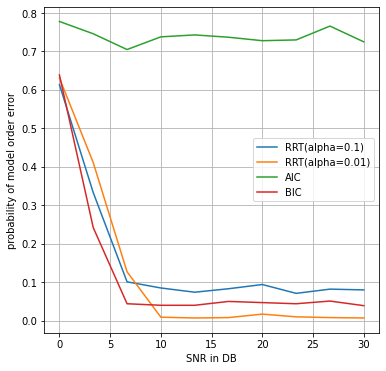

In [14]:
plt.figure(figsize=(6,6))
plt.plot(SNR_db,PROBABILITY_MODEL_ORDER_ERROR_RRT1,label='RRT(alpha=0.1)')
plt.plot(SNR_db,PROBABILITY_MODEL_ORDER_ERROR_RRT2,label='RRT(alpha=0.01)')
plt.plot(SNR_db,PROBABILITY_MODEL_ORDER_ERROR_AIC,label='AIC')
plt.plot(SNR_db,PROBABILITY_MODEL_ORDER_ERROR_BIC,label='BIC')
plt.grid()
plt.legend()
plt.xlabel('SNR in DB')
plt.ylabel('probability of model order error')  

